# 04__activities
# analyzing activity levels per element (neg ctrls; between biotypes)

in this notebook, i perform analyses examining the activities of reference tiles in both pool1 and pool2. i compare reference sequences to negative controls, examine reference activities between biotypes, examine how MPRA activity compares to CAGE expression, and determine how many sequences are expressed across cell types.

------

figures in this notebook:
- **Fig 1C, Fig S4, Fig S12**: boxplots comparing reference sequences to negative controls & between biotypes
- **Fig S6**: boxplots comparing biotypes when either randomly selecting TSSs or expression-matching TSSs
- **Fig 1D**: KDE plot comparing CAGE cell type specificity and MPRA cell type specificity
- **Fig S5**: KDE plot comparing mean CAGE expression and mean MPRA activity
- **Fig 1E**: barplot showing % of reference sequences active in 1 or all 3 cell types

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from statsmodels.sandbox.stats import multicomp

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
activ_dir = "../../data/02__activs"
pval_dir = "../../data/03__pvals"
index_dir = "../../data/00__index"

In [4]:
pool1_hela_barc_activ_f = "POOL1__pMPRA1__HeLa__activities_per_barcode.txt"
pool1_hepg2_barc_activ_f = "POOL1__pMPRA1__HepG2__activities_per_barcode.txt"
pool1_k562_barc_activ_f = "POOL1__pMPRA1__K562__activities_per_barcode.txt"

pool1_hela_elem_activ_f = "POOL1__pMPRA1__HeLa__activities_per_element.txt"
pool1_hepg2_elem_activ_f = "POOL1__pMPRA1__HepG2__activities_per_element.txt"
pool1_k562_elem_activ_f = "POOL1__pMPRA1__K562__activities_per_element.txt"

pool1_hela_pvals_f = "POOL1__pMPRA1__HeLa__pvals.txt"
pool1_hepg2_pvals_f = "POOL1__pMPRA1__HepG2__pvals.txt"
pool1_k562_pvals_f = "POOL1__pMPRA1__K562__pvals.txt"

In [5]:
pool1_nocmv_hela_barc_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_barcode.txt"
pool1_nocmv_hepg2_barc_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_barcode.txt"
pool1_nocmv_k562_barc_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_barcode.txt"

pool1_nocmv_hela_elem_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_element.txt"
pool1_nocmv_hepg2_elem_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_element.txt"
pool1_nocmv_k562_elem_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_element.txt"

pool1_nocmv_hela_pvals_f = "POOL1__pNoCMVMPRA1__HeLa__pvals.txt"
pool1_nocmv_hepg2_pvals_f = "POOL1__pNoCMVMPRA1__HepG2__pvals.txt"
pool1_nocmv_k562_pvals_f = "POOL1__pNoCMVMPRA1__K562__pvals.txt"

In [6]:
pool2_hepg2_barc_activ_f = "POOL2__pMPRA1__HepG2__activities_per_barcode.txt"
pool2_k562_barc_activ_f = "POOL2__pMPRA1__K562__activities_per_barcode.txt"

pool2_hepg2_elem_activ_f = "POOL2__pMPRA1__HepG2__activities_per_element.txt"
pool2_k562_elem_activ_f = "POOL2__pMPRA1__K562__activities_per_element.txt"

pool2_hepg2_pvals_f = "POOL2__pMPRA1__HepG2__pvals.txt"
pool2_k562_pvals_f = "POOL2__pMPRA1__K562__pvals.txt"

In [7]:
pool1_index_f = "%s/tss_oligo_pool.index.txt" % index_dir
pool2_index_f = "%s/dels_oligo_pool.index.txt" % index_dir

In [8]:
annot_f = "../../misc/00__tss_properties/mpra_id_to_biotype_map.txt"
id_map_f = "../../misc/00__tss_properties/mpra_tss_detailed_info.txt"
enh_id_map_f = "../../misc/00__tss_properties/enhancer_id_map.txt"
sel_map_f = "../../misc/00__tss_properties/mpra_tss_selection_info.txt"
cage_exp_f = "../../misc/01__cage/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt"
rna_seq_exp_f = "../../misc/01__cage/Expression.all.cells.txt"

In [9]:
pool1_phylop_f = "../../data/00__index/pool1_tss.phylop46way.txt"

## 1. import data

In [10]:
pool1_index = pd.read_table(pool1_index_f, sep="\t")
pool2_index = pd.read_table(pool2_index_f, sep="\t")

In [11]:
pool1_index_elem = pool1_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]
pool2_index_elem = pool2_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]

pool1_index_elem = pool1_index_elem.drop_duplicates()
pool2_index_elem = pool2_index_elem.drop_duplicates()

In [12]:
annot = pd.read_table(annot_f, sep="\t")
annot.head()

,seqID,PromType2
0,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,div_lnc
1,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,div_lnc
2,FLIPPED__Lincrna.flip.antisense__chr1:10073163...,div_lnc
3,FLIPPED__mrna.flip.antisense__chr1:100731714.....,div_pc
4,WILDTYPE__mrna.flip.sense__chr1:100731714..100...,div_pc


In [13]:
id_map = pd.read_table(id_map_f, sep="\t")
id_map.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


In [14]:
sel_map = pd.read_table(sel_map_f, sep="\t")
sel_map.head()

,oligo_reg,TSS_id,selected,PromType2
0,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",mRNA.random,protein_coding
1,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",mRNA.random,protein_coding
2,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",mRNA.gwas,protein_coding
3,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",mRNA.expmatch,protein_coding
4,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",mRNA.expmatch,protein_coding


In [15]:
enh_id_map = pd.read_table(enh_id_map_f, sep="\t")
enh_id_map.head()

,enhancer_id,TSS_id_Neg,TSS_id_Pos,distTSSs,sum_1828_samples,avExpALL,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,avExpCS,oligo_reg_Neg,oligo_reg_Pos
0,chr1:1004646-1004986,"chr1:1004724..1004725,-","chr1:1004806..1004807,+",239,2186.660,1.196204,1.75865,1.718966,0.0,0.278501,0.634142,0.471889,0.224833,0.0,0.193772,0.586750,"chr1:1004690..1004804,-","chr1:1004727..1004841,+"
1,chr1:108483614-108484145,"chr1:108483919..108483920,-","chr1:108484014..108484015,+",706,949.696,0.519527,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108483885..108483999,-","chr1:108483935..108484049,+"
2,chr1:108592862-108593109,"chr1:108592862..108592863,-","chr1:108592945..108592946,+",84,1794.280,0.981554,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108592828..108592942,-","chr1:108592866..108592980,+"
3,chr1:109099158-109099479,"chr1:109099171..109099172,-","chr1:109099303..109099304,+",159,1366.590,0.747588,0.00000,0.000000,0.0,0.000000,0.000000,0.078648,0.000000,0.0,0.000000,0.008739,"chr1:109099137..109099251,-","chr1:109099224..109099338,+"
4,chr1:109788948-109789150,"chr1:109788975..109788976,-","chr1:109789149..109789150,+",229,2093.390,1.145181,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:109788941..109789055,-","chr1:109789070..109789184,+"


In [16]:
cage_exp = pd.read_table(cage_exp_f, sep="\t")
cage_exp.head()

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"chr10:100013403..100013414,-",0.023403,0.993829,0.666667,38,tissue-specific
1,"chr10:100027943..100027958,-",5.375834,0.968756,0.666667,346,moderate
2,"chr10:100076685..100076699,+",0.012479,0.984646,NaN,34,tissue-specific
3,"chr10:100150910..100150935,-",0.155925,0.991970,NaN,80,moderate
4,"chr10:100150951..100150962,-",0.038083,0.981522,NaN,49,tissue-specific


In [17]:
rna_seq_exp = pd.read_table(rna_seq_exp_f, sep="\t")
rna_seq_exp.head()

,gene_id,A549,GM12878,H1-hESC,HUVEC,HeLa-S3,HepG2,IMR90,K562,MCF-7,NHEK,SK-N-SH
0,ENSG00000000003.10,31.920162,0.012392,39.989468,47.588514,34.921604,46.439177,10.383956,0.242817,24.534779,13.546740,15.400938
1,ENSG00000000005.5,0.000000,0.000000,0.729510,0.000000,0.000000,0.052697,0.000000,0.000000,0.012272,0.000000,0.000000
2,ENSG00000000419.8,34.321019,54.130236,22.474711,22.001707,80.122759,58.227585,42.266614,52.947538,119.129811,50.828462,64.445213
3,ENSG00000000457.9,4.715796,9.902367,2.222304,2.693052,8.641308,2.948341,3.283652,6.761766,7.120837,4.792727,6.164291
4,ENSG00000000460.12,11.382585,20.353400,12.625342,6.522418,34.807272,6.199940,3.842012,27.191509,15.206148,5.591343,3.786800


In [18]:
pool1_phylop = pd.read_table(pool1_phylop_f, sep="\t", header=None)
cols = ["chr", "start", "end", "unique_id", "score", "strand", "length"]
cols.extend(list(np.arange(-80, 34)))
pool1_phylop.columns = cols
pool1_phylop.head()

,chr,start,end,unique_id,score,strand,length,-80,-79,-78,...,24,25,26,27,28,29,30,31,32,33
0,chr10,102046079,102046193,SCRAMBLED__mrna.noflip.NA__chr10:102046079..10...,1,-,114,0.00,0.00,0.00,...,-0.63,-0.68,-0.07,1.15,-0.24,1.09,0.79,-0.30,-0.02,1.00
1,chr10,102046079,102046193,WILDTYPE__mrna.noflip.NA__chr10:102046079..102...,1,-,114,0.00,0.00,0.00,...,-0.63,-0.68,-0.07,1.15,-0.24,1.09,0.79,-0.30,-0.02,1.00
2,chr10,102133304,102133418,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr10...,1,+,114,0.82,0.20,0.16,...,0.39,-0.21,-0.62,0.62,-0.57,-0.16,-1.03,1.03,-1.28,-0.32
3,chr10,102133304,102133418,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__chr10:1...,1,+,114,0.82,0.20,0.16,...,0.39,-0.21,-0.62,0.62,-0.57,-0.16,-1.03,1.03,-1.28,-0.32
4,chr10,1034322,1034436,FLIPPED__mrna.flip.antisense__chr10:1034322..1...,1,-,114,2.07,2.07,1.26,...,-2.21,-0.61,-2.42,-0.18,2.22,0.41,0.64,2.22,1.80,-0.05


### pool 1

In [19]:
pool1_hela_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_elem_activ_f), sep="\t")
pool1_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,-1.229482,-1.201427,-1.207830,-1.138838
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,-0.264065,-0.260860,-0.300284,-0.182098
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,-0.534859,-0.557712,-0.578824,-0.754250
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,-1.250940,-1.065514,-1.058389,-1.399819
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,0.180815,0.251183,0.186228,0.145362


In [20]:
pool1_hela_reps = [x for x in pool1_hela_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps = [x for x in pool1_hepg2_elem_norm.columns if "rna_" in x]
pool1_k562_reps = [x for x in pool1_k562_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps

['rna_3',
 'rna_4',
 'rna_5',
 'rna_6',
 'rna_7',
 'rna_8',
 'rna_9',
 'rna_10',
 'rna_11',
 'rna_12',
 'rna_13',
 'rna_14']

In [21]:
pool1_hela_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_barc_activ_f), sep="\t")
pool1_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,AAAACAAAGTC,-0.232915,-0.409743,-0.830252,-0.558582,0.259745,0.471566,0.137889,0.605610,-0.115982,0.389549,0.251261,0.360733
1,AAAACAAAGTT,-1.641943,-1.786002,NaN,NaN,NaN,-1.472057,-2.748240,0.123337,-3.569422,-0.959375,-2.188633,-1.877116
2,AAAACAAATGT,0.445553,0.331374,0.022147,-0.308519,0.782481,0.935864,0.411982,0.688970,0.972243,0.836551,0.892322,0.819801
3,AAAACAACGTC,-0.010666,1.834886,1.047326,-0.196539,0.456452,0.568126,0.930430,1.951003,0.654473,1.429290,2.026544,1.170410
4,AAAACAACGTG,0.339223,0.864835,-1.879958,-0.186074,0.235210,-1.084751,1.190649,1.043910,-1.136628,0.028256,0.408414,0.148594


In [22]:
pool1_hela_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hela_pvals_f), sep="\t")
pool1_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hepg2_pvals_f), sep="\t")
pool1_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_k562_pvals_f), sep="\t")
pool1_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.403405,0.330523,0.485259,0.487744,0.419931,0.289986,0.127793,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,CONTROL_BUT_HAS_SNP,1.146015,0.949856,1.324285,1.245177,1.331950,1.112834,0.963992,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,CONTROL_BUT_HAS_SNP,0.654683,0.618780,0.782989,0.782589,0.857763,0.969354,0.618092,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,CONTROL_BUT_HAS_SNP,0.344792,0.375084,0.052049,0.452240,0.243133,0.199732,0.396825,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.574229,1.580879,1.730772,1.652956,1.637522,1.661432,1.461112,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [23]:
pool2_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_elem_activ_f), sep="\t")
pool2_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_elem_activ_f), sep="\t")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183


In [24]:
pool2_hepg2_reps = [x for x in pool2_hepg2_elem_norm.columns if "rna_" in x]
pool2_k562_reps = [x for x in pool2_k562_elem_norm.columns if "rna_" in x]
pool2_hepg2_reps

['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10']

In [25]:
pool2_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_barc_activ_f), sep="\t")
pool2_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_barc_activ_f), sep="\t")
pool2_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,AAAACAAAGTC,NaN,NaN,0.559995,NaN,NaN,NaN,NaN,NaN
1,AAAACAACGTG,-1.780485,-0.598085,-1.170739,-0.878212,-1.162959,-1.45008,-0.133118,-1.089508
2,AAAACAACTGG,NaN,NaN,-2.425661,NaN,NaN,NaN,NaN,NaN
3,AAAACAAGATG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAACAAGATT,-1.028853,-1.208253,-3.278023,NaN,-2.543835,-4.28303,-1.792000,-0.798199


In [26]:
pool2_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_hepg2_pvals_f), sep="\t")
pool2_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_k562_pvals_f), sep="\t")
pool2_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_BUT_HAS_SNP,-0.740530,-0.483852,-0.266400,-0.420682,-0.565798,-0.276644,-0.338944,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.395869,0.428595,0.382347,0.279643,0.291139,0.361236,0.427300,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,CONTROL_BUT_HAS_SNP,-0.160006,-0.241741,-0.140360,-0.096893,-0.253929,-0.164211,-0.046484,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.519378,1.814816,1.483085,1.542379,1.720079,1.566608,1.711800,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_SNP_INDIV,-0.652900,-0.634970,-0.355650,-0.403086,-0.509460,-0.427165,-0.256770,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 2. merge with index

### pool 1

In [27]:
wt_index = pool1_index_elem.merge(annot, left_on="unique_id", right_on="seqID")
wt_index = wt_index[wt_index["oligo_type"].isin(["WILDTYPE", "WILDTYPE_BUT_HAS_SNP"])]
wt_index.sample(5)

,element,oligo_type,unique_id,dupe_info,SNP,seqID,PromType2
2062,GCCGCGGGGGGCGTGGCCGCGGGGGCGCGCGGGGATATCCGGGGGC...,WILDTYPE,WILDTYPE__mrna.noflip.NA__chr16:1464670..14647...,none,none,WILDTYPE__mrna.noflip.NA__chr16:1464670..14647...,protein_coding
2724,CGAGAGTTCAACTTCCTGACTAGGAGCCAATCAGCGGGGCCGCCTC...,WILDTYPE_BUT_HAS_SNP,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr3:48...,none,none,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr3:48...,protein_coding
3116,TGCCAAAACCTAAGGTGATGTTGTGGTTGGTTTAATTTTTTTTCTT...,WILDTYPE,WILDTYPE__Enhancer.noflip.NA__chr4:69814099..6...,none,none,WILDTYPE__Enhancer.noflip.NA__chr4:69814099..6...,Enhancer
3481,CCACCTCTATGGTGTCGGCGAAGACCCGCCCTTGTGACGTCACGGA...,WILDTYPE_BUT_HAS_SNP,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,none,none,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,Enhancer
3038,GCCGTTAGGGAGGGAGTGTTCACCGGAAACCTGCCCGGGCCACACG...,WILDTYPE_BUT_HAS_SNP,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,none,none,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,Enhancer


In [28]:
wt_index.PromType2.value_counts()

protein_coding    599
Enhancer          564
intergenic        425
div_lnc           353
antisense         144
div_pc            137
Name: PromType2, dtype: int64

In [29]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")

In [30]:
pool1_hela_barc_norm = pool1_hela_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_hepg2_barc_norm = pool1_hepg2_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_k562_barc_norm = pool1_k562_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")

In [31]:
pool1_hela_elem_norm["better_type"] = pool1_hela_elem_norm.apply(better_type, axis=1)
pool1_hepg2_elem_norm["better_type"] = pool1_hepg2_elem_norm.apply(better_type, axis=1)
pool1_k562_elem_norm["better_type"] = pool1_k562_elem_norm.apply(better_type, axis=1)

In [32]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_hela_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [33]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")

In [34]:
pool2_hepg2_barc_norm = pool2_hepg2_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")
pool2_k562_barc_norm = pool2_k562_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")

In [35]:
pool2_hepg2_elem_norm["better_type"] = pool2_hepg2_elem_norm.apply(better_type, axis=1)
pool2_k562_elem_norm["better_type"] = pool2_k562_elem_norm.apply(better_type, axis=1)

In [36]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 3. count significantly active/inactive tiles

### pool 1

In [37]:
pool1_hela_elem_norm["overall_mean"] = pool1_hela_elem_norm[pool1_hela_reps].mean(axis=1)
pool1_hepg2_elem_norm["overall_mean"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].mean(axis=1)
pool1_k562_elem_norm["overall_mean"] = pool1_k562_elem_norm[pool1_k562_reps].mean(axis=1)

pool1_hela_elem_norm["overall_median"] = pool1_hela_elem_norm[pool1_hela_reps].median(axis=1)
pool1_hepg2_elem_norm["overall_median"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].median(axis=1)
pool1_k562_elem_norm["overall_median"] = pool1_k562_elem_norm[pool1_k562_reps].median(axis=1)

In [38]:
for cell, df in zip(["HeLa", "HepG2", "K562"], [pool1_hela_elem_norm, pool1_hepg2_elem_norm, pool1_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HeLa: combined class
not sig           6384
sig active         765
sig repressive       3
Name: combined_class, dtype: int64

HepG2: combined class
not sig           4449
sig active        2677
sig repressive      26
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           4672
sig active        2474
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           5127
sig active        2013
sig repressive      12
Name: combined_class, dtype: int64



### pool 2

In [39]:
pool2_hepg2_elem_norm["overall_mean"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].mean(axis=1)
pool2_k562_elem_norm["overall_mean"] = pool2_k562_elem_norm[pool2_k562_reps].mean(axis=1)

pool2_hepg2_elem_norm["overall_median"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].median(axis=1)
pool2_k562_elem_norm["overall_median"] = pool2_k562_elem_norm[pool2_k562_reps].median(axis=1)

In [40]:
for cell, df in zip(["HepG2", "K562"], [pool2_hepg2_elem_norm, pool2_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HepG2: combined class
not sig           8213
sig active         175
sig repressive       1
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           8214
sig active         169
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           8289
sig active          88
sig repressive      12
Name: combined_class, dtype: int64



## 4. boxplots: neg ctrls vs reference

In [41]:
pool1_hepg2_df = pool1_hepg2_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hela_df = pool1_hela_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_k562_df = pool1_k562_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding


In [42]:
pool1_hepg2_df["oligo_reg"] = pool1_hepg2_df.unique_id.str.split("__", expand=True)[2]
pool1_hela_df["oligo_reg"] = pool1_hela_df.unique_id.str.split("__", expand=True)[2]
pool1_k562_df["oligo_reg"] = pool1_k562_df.unique_id.str.split("__", expand=True)[2]
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding,"chr11:5248266..5248380,-"
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control,"chr16:67993585..67993700,+"
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:33571488..33571603,+"
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:76375037..76375152,+"
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding,"chr1:153518247..153518361,-"


In [43]:
def add_neg_ctrl_promtype(row):
    if row["better_type"] == "RANDOM":
        return "random"
    elif row["better_type"] == "SCRAMBLED":
        return "scrambled"
    elif row["better_type"] == "CONTROL":
        return "control"
    else:
        return row["PromType2"]

In [44]:
pool1_hepg2_df["PromType2"] = pool1_hepg2_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_hela_df["PromType2"] = pool1_hela_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_k562_df["PromType2"] = pool1_k562_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_hepg2_df.sample(10)

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg
743,RANDOM__random_sequence__randSeq__1149.1,TGCGCCCCGATCTGGGAGCGGTAGTGTATTTTCGTCCACACATTTT...,-1.434015,-2.376075,-0.252912,-0.201903,-1.455038,-0.682735,-2.733130,-1.298111,...,NaN,NaN,not sig,not sig,not sig,-1.600968,-1.570495,RANDOM__random_sequence__randSeq__1149.1,random,randSeq
1986,RANDOM__random_sequence__randSeq__838.1,AAATTCTACTCACACTCCTACTGGTTGCGTGCTTTTTCGGACCAGC...,-1.141250,-0.600754,-0.057626,-0.761839,-0.804082,0.133395,-0.283380,-0.269984,...,NaN,NaN,not sig,not sig,not sig,-0.429556,-0.386500,RANDOM__random_sequence__randSeq__838.1,random,randSeq
4890,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__chr4:18...,GGAAACACAATCAAATTAACTTTCCAGTCACCGCTGTGTCTAGGTG...,-1.877511,-2.042036,-1.779266,-2.148990,-1.507178,-1.776122,-1.681829,-1.839411,...,1.000000e+00,not sig,not sig,not sig,not sig,-1.804696,-1.809338,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__chr4:18...,intergenic,"chr4:185776772..185776886,-"
6868,WILDTYPE__mrna.flip.sense__chr15:40331342..403...,AGGCCGGGATTGGTGGAAGAGAAGAGATTGGTGGAAGACAATGGAA...,3.160018,3.796946,2.942671,2.816264,3.174727,3.305510,2.972737,3.245179,...,1.798200e-110,sig,sig active,sig,sig active,3.227660,3.235976,WILDTYPE__mrna.flip.sense__chr15:40331342..403...,div_pc,"chr15:40331342..40331456,-"
1136,RANDOM__random_sequence__randSeq__1502.1,CATTCTGCTACTCTGTGAAGTCGACGGTTCAATAAGAAGAATCCAA...,-1.891122,-1.310336,-1.839584,-2.936613,-0.809923,-0.949735,-1.869972,-2.129945,...,NaN,NaN,not sig,not sig,not sig,-1.419109,-1.184929,RANDOM__random_sequence__randSeq__1502.1,random,randSeq
1208,RANDOM__random_sequence__randSeq__1568.1,AGGCGGATGAATATGACGCACACTGTCTGGAATTGCTTTGAGCCCG...,1.170570,1.326671,0.191107,1.049043,0.978348,1.034613,1.224696,0.249340,...,NaN,NaN,not sig,not sig,not sig,1.032020,1.133280,RANDOM__random_sequence__randSeq__1568.1,random,randSeq
157,FLIPPED__Antisense.flip.antisense__chr6:302945...,GGCCGCGGCCGCCCGCCGACACCCCAGCTTCCACTGACACGAGCCT...,1.234644,-0.352042,NaN,NaN,-1.082175,-1.384271,NaN,-2.574709,...,NaN,NaN,not sig,not sig,not sig,-0.713663,-0.910867,FLIPPED__Antisense.flip.antisense__chr6:302945...,div_lnc,"chr6:30294598..30294712,+"
4016,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr2:219...,CCGCTCTCCCTGACTAGGGGTAGCTAGCGGCCTCCCTCCTTTGGGT...,-0.636909,-0.543714,-0.542609,-1.055037,-0.531346,-0.459848,-0.830892,-0.855603,...,1.257095e-30,sig,sig active,sig,sig active,-0.697464,-0.684099,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr2:219...,protein_coding,"chr2:219432929..219433043,-"
2488,SCRAMBLED__Enhancer.noflip.NA__chr2:162197429....,CAGGAGCCAGAGGTTGCCCGGGGGCCGGAGGAGGGGGGCAGGGGCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,not sig,not sig,not sig,NaN,NaN,SCRAMBLED__Enhancer.noflip.NA__chr2:162197429....,scrambled,"chr2:162197429..162197543,-"
4804,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__chr10:6...,GTGCTTGATGCAGTCTGATAGGAGGATGGGGGTGGCGCGGAGAACA...,-1.790830,-1.414968,-1.314713,-1.539696,-1.478538,-1.235750,-1.471418,-0.815159,...,1.000000e+00,not sig,not sig,not sig,not sig,-1.393074,-1.443193,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__chr10:6...,intergenic,"chr10:60759312..60759426,+"


### pool 1

y_1: 10.4222491243, y_2: 7.65548793575
rand_pval: 1.32497538616e-30, scram_pval: 4.72968645318e-11
y_1: 9.11162925866, y_2: 6.97674620744
rand_pval: 1.17132621074e-274, scram_pval: 1.00414951338e-119
y_1: 9.12774548177, y_2: 6.68905587429
rand_pval: 2.75667614727e-181, scram_pval: 5.01255506218e-74


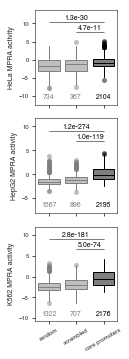

In [45]:
order = ["RANDOM", "SCRAMBLED", "WILDTYPE"]
palette = {"RANDOM": "gray", "SCRAMBLED": "gray", "WILDTYPE": "black"}

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(1.78, 5))
neg_control_plot(pool1_hela_elem_norm, order, palette, fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool1_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool1_k562_elem_norm, order, palette, fontsize, "K562", axarr[2], None, "K562 MPRA activity", 
                 False, False, False, None)
plt.tight_layout()

### pool 2

y_1: 9.42783493857, y_2: 7.23987496313
rand_pval: 5.11647933556e-17, scram_pval: 7.90973564244e-10
y_1: 8.26308778415, y_2: 5.97168986664
rand_pval: 2.58113913894e-06, scram_pval: 0.00122751191285


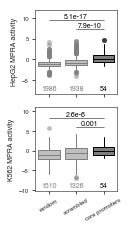

In [46]:
f, axarr = plt.subplots(2, sharex=True, sharey=False, figsize=(1.78, 3.2))
neg_control_plot(pool2_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[0], None, "HepG2 MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool2_k562_elem_norm, order, palette, fontsize, "K562", axarr[1], None, "K562 MPRA activity", 
                 False, False, False, None)
plt.tight_layout()
f.savefig("Fig_S12.pdf", bbox_inches="tight", dpi="figure")

## 5. boxplots: across TSS classes

In [47]:
palette = {"random": "gray", "scrambled": "gray", "Enhancer": sns.color_palette("deep")[1], 
           "intergenic": sns.color_palette("deep")[2], "protein_coding": sns.color_palette("deep")[5], 
           "div_lnc": sns.color_palette("deep")[3], "div_pc": sns.color_palette("deep")[0]}

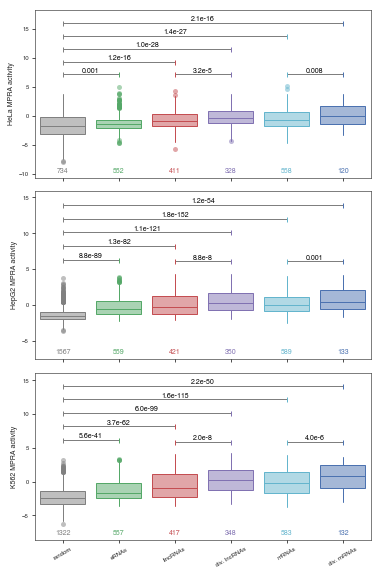

In [48]:
# random
order = ["random", "Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["random", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(5.3, 8))
promtype_plot(pool1_hela_df, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None, True)
promtype_plot(pool1_hepg2_df, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None, True)
promtype_plot(pool1_k562_df, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None, True)
plt.tight_layout()
f.savefig("FigS4.pdf", bbox_inches="tight", dpi="figure")

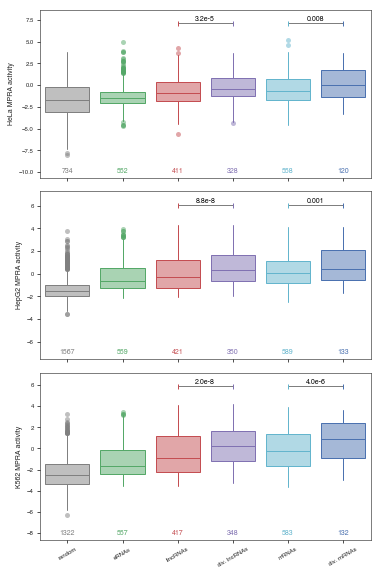

In [49]:
# random
order = ["random", "Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["random", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(5.3, 8))
promtype_plot(pool1_hela_df, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None, False)
promtype_plot(pool1_hepg2_df, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None, False)
promtype_plot(pool1_k562_df, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None, False)
plt.tight_layout()
f.savefig("Fig1C.pdf", bbox_inches="tight", dpi="figure")

## expression-match

In [50]:
def fix_enh_cage_id(row):
    if row.PromType2 == "Enhancer":
        if not pd.isnull(row.enhancer_id_x):
            return row.enhancer_id_x
        elif not pd.isnull(row.enhancer_id_y):
            return row.enhancer_id_y
        else:
            return np.nan
    else:
        return row.cage_id

In [51]:
sel_map["cage_id"] = sel_map["TSS_id"]
sel_map = sel_map.merge(enh_id_map[["TSS_id_Pos", "enhancer_id"]],
                        left_on="TSS_id", right_on="TSS_id_Pos", how="left")
sel_map = sel_map.merge(enh_id_map[["TSS_id_Neg", "enhancer_id"]],
                        left_on="TSS_id", right_on="TSS_id_Neg", how="left")
sel_map["cage_id"] = sel_map.apply(fix_enh_cage_id, axis=1)
sel_map.drop(["TSS_id_Pos", "enhancer_id_x", "TSS_id_Neg", "enhancer_id_y"], axis=1, inplace=True)
sel_map_expr = sel_map.merge(cage_exp, on="cage_id", how="left")
sel_map_expr.sample(5)

,oligo_reg,TSS_id,selected,PromType2,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
46,"chr10:6622203..6622317,+","chr10:6622204..6622254,-",mRNA.bidirec70-160,div_pc,"chr10:6622204..6622254,-",2.733000,0.939771,0.634778,324.0,moderate
1940,"chr4:66536255..66536369,-","chr4:66536306..66536345,+",lncRNA,div_lnc,"chr4:66536306..66536345,+",0.829742,0.961747,0.666667,240.0,moderate
285,"chr1:8021691..8021805,+","chr1:8021713..8021788,+",mRNA.gwas,protein_coding,"chr1:8021713..8021788,+",73.111841,0.615354,0.046048,550.0,ubiquitous
1811,"chr5:147763427..147763541,+","chr5:147763388..147763474,-",lncRNA,div_lnc,"chr5:147763388..147763474,-",1.663373,0.930088,0.324396,460.0,moderate
1652,"chr1:40974319..40974433,+","chr1:40974347..40974387,-",lncRNA,div_lnc,"chr1:40974347..40974387,-",2.457212,0.940320,0.474561,517.0,ubiquitous


In [52]:
sel_map_expr["log_av_exp"] = np.log10(sel_map_expr["av_exp"])
sel_map_expr.selected.unique()

array(['mRNA.random', 'mRNA.gwas', 'mRNA.expmatch', 'mRNA.bidirec70-160',
       'lncRNA', 'control.eQTLprom', 'control.prom', 'lncRNA.gwas',
       'eRNA.random', 'eRNA.expmatch', 'eRNA.gwas', 'eRNA.highlyexp',
       'control.eQTL', 'control.enhancer'], dtype=object)

In [53]:
rand_sel_types = ["lncRNA", "eRNA.random", "mRNA.random", "mRNA.bidirec70-160"]

In [54]:
rand_sel_ids = sel_map_expr[sel_map_expr["selected"].isin(rand_sel_types)]

In [55]:
rand_sel_ids.PromType2.value_counts()

div_lnc           526
intergenic        487
Enhancer          218
protein_coding    204
antisense         189
div_pc            187
Name: PromType2, dtype: int64

In [56]:
def get_matching_pairs(df_1, df_2, col, scaler=True):

    x_1 = np.asarray(df_1[col])
    x_2 = np.asarray(df_2[col])
    x_1 = np.reshape(x_1, (len(df_1), 1))
    x_2 = np.reshape(x_2, (len(df_2), 1))

    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(x_2)
        x_2 = scaler.transform(x_2)
        x_1 = scaler.transform(x_1)
        
    nbrs = NearestNeighbors(n_neighbors=1).fit(x_2)
    distances, indices = nbrs.kneighbors(x_1)
    indices = indices.reshape(indices.shape[0])
    matched = df_2.ix[indices]
    return matched

In [57]:
# match every biotype to the selected lncRNAs
promtypes = ["Enhancer", "protein_coding", "div_lnc", "div_pc"]
lncRNAs = sel_map_expr[(sel_map_expr["selected"] == "lncRNA") & 
                       (sel_map_expr["PromType2"] == "intergenic")].drop_duplicates()

print("total selected lncRNAs: %s" % len(lncRNAs))
print("min lncRNA expression: %s" % np.min(lncRNAs["av_exp"]))
print("max lncRNA expression: %s" % np.max(lncRNAs["av_exp"]))

all_matched = lncRNAs.copy()
for promtype in promtypes:
    sub_df = sel_map_expr[sel_map_expr["PromType2"] == promtype].drop_duplicates().reset_index()
    matched = get_matching_pairs(lncRNAs, sub_df, col="log_av_exp")
    print("%s (total=%s, matched=%s)" % (promtype, len(sub_df), len(matched)))
    all_matched = all_matched.append(matched)
all_matched = all_matched.drop_duplicates()

total selected lncRNAs: 487
min lncRNA expression: 0.0226472457484
max lncRNA expression: 9758.48618928
Enhancer (total=722, matched=487)
protein_coding (total=719, matched=487)
div_lnc (total=526, matched=487)
div_pc (total=232, matched=487)


In [58]:
all_matched.PromType2.value_counts()

intergenic        487
protein_coding    247
div_lnc           213
Enhancer          167
div_pc             87
Name: PromType2, dtype: int64

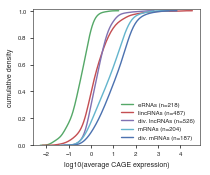

In [59]:
label_dict = {"Enhancer": "eRNAs", "intergenic": "lincRNAs", "div_lnc": "div. lncRNAs", "protein_coding": "mRNAs",
              "div_pc": "div. mRNAs"}
distplot_biotypes(rand_sel_ids, (3, 2.5), palette, label_dict, (0, 1.01), "log10(average CAGE expression)", False, None)

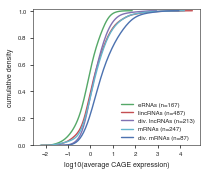

In [60]:
distplot_biotypes(all_matched, (3, 2.5), palette, label_dict, (0, 1.01), "log10(average CAGE expression)", False, None)

In [61]:
pool1_hela_rand = pool1_hela_df[pool1_hela_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]
pool1_hepg2_rand = pool1_hepg2_df[pool1_hepg2_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]
pool1_k562_rand = pool1_k562_df[pool1_k562_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]

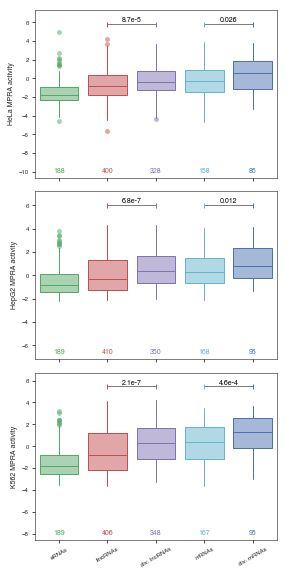

In [62]:
order = ["Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_rand, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None, False)
promtype_plot(pool1_hepg2_rand, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None, False)
promtype_plot(pool1_k562_rand, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None, False)
plt.tight_layout()
f.savefig("FigS6_1.pdf", bbox_inches="tight", dpi="figure")

In [63]:
pool1_hela_exp = pool1_hela_df[pool1_hela_df["oligo_reg"].isin(all_matched["oligo_reg"])]
pool1_hepg2_exp = pool1_hepg2_df[pool1_hepg2_df["oligo_reg"].isin(all_matched["oligo_reg"])]
pool1_k562_exp = pool1_k562_df[pool1_k562_df["oligo_reg"].isin(all_matched["oligo_reg"])]

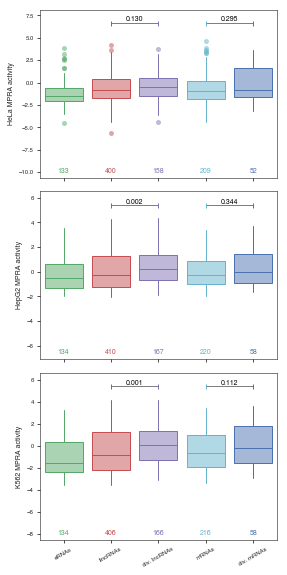

In [64]:
f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_exp, order, palette, labels, 
              fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", False, False, False, None, False)
promtype_plot(pool1_hepg2_exp, order, palette, labels, 
              fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", False, False, False, None, False)
promtype_plot(pool1_k562_exp, order, palette, labels, 
              fontsize, "K562", axarr[2], None, "K562 MPRA activity", False, False, False, None, False)
plt.tight_layout()
f.savefig("FigS6_2.pdf", bbox_inches="tight", dpi="figure")

the rest of the analysis only uses pool 1 (the TSS pool), as it looks at patterns in expression differences between TSS classes

## 6. barplots: find % of sequences active across cell types

In [65]:
pool1_hela_df["cell"] = "HeLa"
pool1_hepg2_df["cell"] = "HepG2"
pool1_k562_df["cell"] = "K562"

all_df = pool1_hela_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]].append(pool1_hepg2_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]]).append(pool1_k562_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]])

In [66]:
df = all_df[all_df["better_type"] == "WILDTYPE"]
activ_grp = df.groupby("unique_id")["cell", "combined_class"].agg(lambda x: list(x)).reset_index()
activ_grp = activ_grp.merge(annot, left_on="unique_id", right_on="seqID", how="left").drop("seqID", axis=1)
activ_grp = activ_grp[(activ_grp["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(activ_grp["unique_id"].str.contains("SCRAMBLED"))]
activ_grp.sample(10)

,unique_id,cell,combined_class,PromType2
1047,WILDTYPE__Antisense.flip.sense__chr2:61372069....,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",div_lnc
1388,WILDTYPE__Enhancer.noflip.NA__chr10:95197193.....,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
381,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr7...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",Enhancer
615,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr5:33...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",div_pc
892,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr4:119...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",protein_coding
1312,WILDTYPE__Enhancer.flip.sense__chr16:68271578....,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",Enhancer
1748,WILDTYPE__Lincrna.noflip.NA__chr1:202830822..2...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",intergenic
1605,WILDTYPE__Enhancer.noflip.NA__chr8:42398432..4...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
1826,WILDTYPE__Lincrna.noflip.NA__chr4:39640748..39...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",div_lnc
2018,WILDTYPE__mrna.flip.sense__chr8:90769909..9077...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",div_pc


In [67]:
activ_grp["active_in_only_one"] = activ_grp.apply(active_in_only_one, axis=1)
activ_grp["active_in_only_two"] = activ_grp.apply(active_in_only_two, axis=1)
activ_grp["active_in_only_three"] = activ_grp.apply(active_in_only_three, axis=1)
activ_grp.sample(5)

,unique_id,cell,combined_class,PromType2,active_in_only_one,active_in_only_two,active_in_only_three
447,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr12...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",intergenic,False,False,False
530,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr7:...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",intergenic,True,False,False
996,WILDTYPE__Antisense.flip.sense__chr11:10562731...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",div_lnc,False,False,False
2120,WILDTYPE__mrna.noflip.NA__chr1:173793248..1737...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",protein_coding,False,True,False
948,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr7:802...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",protein_coding,False,False,False


In [68]:
for PromType2 in TSS_CLASS_ORDER:
    df = activ_grp[activ_grp["PromType2"] == PromType2]
    active_in_1 = len(df[df["active_in_only_one"]])
    active_in_3 = len(df[df["active_in_only_three"]])
    print("%s | active in 1: %s, active in 3: %s" % (PromType2, active_in_1, active_in_3))

Enhancer | active in 1: 146, active in 3: 24
intergenic | active in 1: 78, active in 3: 69
div_lnc | active in 1: 60, active in 3: 77
protein_coding | active in 1: 97, active in 3: 105
div_pc | active in 1: 10, active in 3: 41


In [69]:
activ_counts_1 = activ_grp.groupby(["PromType2", "active_in_only_one"])["unique_id"].agg("count").reset_index()
activ_pcts_1 = activ_counts_1.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_1["percent"] = activ_pcts_1

activ_counts_2 = activ_grp.groupby(["PromType2", "active_in_only_two"])["unique_id"].agg("count").reset_index()
activ_pcts_2 = activ_counts_2.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_2["percent"] = activ_pcts_2

activ_counts_3 = activ_grp.groupby(["PromType2", "active_in_only_three"])["unique_id"].agg("count").reset_index()
activ_pcts_3 = activ_counts_3.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_3["percent"] = activ_pcts_3

activ_counts_1 = activ_counts_1[activ_counts_1["active_in_only_one"]]
activ_counts_2 = activ_counts_2[activ_counts_2["active_in_only_two"]]
activ_counts_3 = activ_counts_3[activ_counts_3["active_in_only_three"]]

activ_counts = activ_counts_1.merge(activ_counts_2, on="PromType2").merge(activ_counts_3, on="PromType2")
activ_counts.drop(["active_in_only_one", "unique_id_x", "active_in_only_two", "unique_id_y", 
                   "active_in_only_three", "unique_id"],
                  axis=1, inplace=True)
activ_counts.columns = ["PromType2", "active_in_only_one", "active_in_only_two", "active_in_only_three"]
activ_counts = pd.melt(activ_counts, id_vars="PromType2")
activ_counts.head()

,PromType2,variable,value
0,Enhancer,active_in_only_one,25.886525
1,div_lnc,active_in_only_one,16.997167
2,div_pc,active_in_only_one,7.299270
3,intergenic,active_in_only_one,18.352941
4,protein_coding,active_in_only_one,16.193656


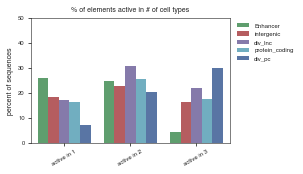

In [70]:
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3.56, 2.3))
ax = sns.barplot(data=df, x="variable", y="value", hue="PromType2", ci=None, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["active in 1", "active in 2", "active in 3"], rotation=30)

plt.legend(bbox_to_anchor=(1.35, 1))
plt.ylim((0, 50))
plt.ylabel("percent of sequences", size=fontsize)
plt.xlabel("")
plt.title("% of elements active in # of cell types")

In [71]:
colors = []
for c in TSS_CLASS_ORDER:
    colors.append(TSS_CLASS_PALETTE[c])
colors

[(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

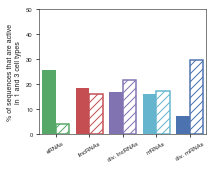

In [72]:
# better plot showing tissue sp
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3,2.3))
ax = sns.barplot(data=df[df["variable"]!="active_in_only_two"], x="PromType2", y="value", 
                 ci=None, hue="variable", linewidth=1.5)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)

colors = colors*2
for i, p in enumerate(ax.patches):
    if i < 5:
        p.set_facecolor(colors[i])
    else:
        p.set_facecolor("white")
        p.set_edgecolor(colors[i])
        p.set_alpha(1)
        p.set_hatch("///")

ax.legend().set_visible(False)
plt.ylim((0, 50))
plt.ylabel("% of sequences that are active\nin 1 and 3 cell types", fontsize=fontsize)
plt.xlabel("")
plt.savefig("Fig_1E.pdf", bbox_inches="tight", dpi="figure")

## 7. kdeplot: compare to CAGE

In [73]:
hepg2_activ = pool1_hepg2_df[["unique_id", "element", "better_type", "overall_mean", "PromType2"]]
hela_activ = pool1_hela_df[["unique_id", "element", "better_type", "overall_mean"]]
k562_activ = pool1_k562_df[["unique_id", "element", "better_type", "overall_mean"]]

all_activ = hepg2_activ.merge(hela_activ, on=["unique_id", "element", "better_type"], how="left").merge(k562_activ, on=["unique_id", "element", "better_type"], how="left")
all_activ.columns = ["unique_id", "element", "better_type", "HepG2", "PromType2", "HeLa", "K562"]
all_activ = all_activ[["unique_id", "element", "better_type", "PromType2", "HepG2", "HeLa", "K562"]]
all_activ = all_activ[(all_activ["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(all_activ["unique_id"].str.contains("SCRAMBLED")) &
                      (all_activ["better_type"] == "WILDTYPE")]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562
6669,WILDTYPE__Lincrna.noflip.NA__chr17:70588908..7...,CCTCCCCGCCCACCCCGCTCCGCCCCGTCCCGGCGCGGGTCCGCCT...,WILDTYPE,intergenic,0.321682,NaN,NaN
6888,WILDTYPE__mrna.flip.sense__chr1:204042163..204...,TTCTGCAAGTCCCCACCCTCCCTCCCTCCTCCCCCTGCGCGCTCTC...,WILDTYPE,protein_coding,-0.441773,-1.555900,0.558127
6814,WILDTYPE__Lincrna.noflip.NA__chr8:65285786..65...,GAGAGAACGCAGAGGGAGGGAGGCAGGGAGGGAGACCAAACCCCCG...,WILDTYPE,intergenic,-1.228722,-1.711918,-2.347740
6996,WILDTYPE__mrna.noflip.NA__chr13:24734779..2473...,TGGCCTGATATGGGGCGGGGGGAAGAGCCGGGCTGGGGGCGTGGCC...,WILDTYPE,protein_coding,0.777560,-0.600073,2.654667
6965,WILDTYPE__mrna.noflip.NA__chr11:118972528..118...,GGCCGCCGCCTTCCGCAGTAATGGTTGTTCAGCGAACAAGATCCGG...,WILDTYPE,protein_coding,-0.224276,0.877701,-2.149341


In [74]:
all_activ["combined_class"] = ""
all_activ = all_activ.merge(pool1_hela_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HeLa")).merge(pool1_hepg2_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HepG2")).merge(pool1_k562_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_K562"))
all_activ.drop("combined_class", axis=1, inplace=True)
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active


In [75]:
all_activ["oligo_reg"] = all_activ.unique_id.str.split("__", expand=True)[2]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,oligo_reg
588,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr9:72...,CTGGCCCCGCCCCAGGTTGCTTAGGAGATAAGAGACGCCGAATCTT...,WILDTYPE,div_pc,-1.456179,-3.173841,-2.693281,not sig,not sig,not sig,"chr9:72435677..72435791,+"
401,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr12...,GGCTCCTCTCAGGGCTCCTTCCCCTGCCCCCATTCCACCCCAGCCC...,WILDTYPE,intergenic,-1.184290,-2.414816,-2.571927,not sig,not sig,not sig,"chr12:30948822..30948936,+"
2048,WILDTYPE__mrna.noflip.NA__chr7:26241289..26241...,CTTCGTGGCCGCCCGGCGTGGGCGGTGCCACCCCTCCCCCCGGCGG...,WILDTYPE,protein_coding,NaN,NaN,NaN,not sig,not sig,not sig,"chr7:26241289..26241403,+"
1078,WILDTYPE__Antisense.noflip.NA__chr2:135676141....,CGCCCTAGTCTTTTGCTTTCTTTTTCTGCCCTCGGCCTCGCTCTTG...,WILDTYPE,div_lnc,1.765048,0.743671,1.829731,sig active,sig active,sig active,"chr2:135676141..135676255,-"
2035,WILDTYPE__mrna.noflip.NA__chr5:173472643..1734...,GCGCGAGCGAGCAAGCAGGCAGGCAGCTGCCAGGAGCTCTTCCCTG...,WILDTYPE,protein_coding,-2.120293,-1.770301,-2.037120,not sig,sig repressive,not sig,"chr5:173472643..173472757,+"


In [76]:
id_map = id_map[["oligo_reg", "gene_id", "K562_rep1", "K562_rep2", "K562_rep3", "HeLa_rep1", "HeLa_rep2", "HeLa_rep3", 
                 "HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]]
all_activ = all_activ.merge(id_map, on="oligo_reg")
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,gene_id,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3
533,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr16:2...,GCCCTTCCCTCCCGCCGCTGTTCTCTATGGTCTCTTCCTTCAGCGA...,WILDTYPE,protein_coding,0.619914,-0.209296,0.331510,not sig,sig active,sig active,...,ENSG00000178188.10,3.835126,6.862189,5.873756,6.772943,6.066413,6.487121,6.539004,6.840516,6.470740
140,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,TCTCTCATCCAATCAGAATATGTAGTCCAGGAACGGCATTTGCATA...,WILDTYPE,Enhancer,1.568638,-1.253408,1.758755,not sig,sig active,sig active,...,NaN,188.175586,140.955197,141.425633,0.000000,0.211381,0.078648,0.224833,0.000000,0.064591
1509,WILDTYPE__Lincrna.flip.sense__chr2:171627474.....,GGCTGCCCCTGCCCCCGCCCCCGCCCCCGCCACCTCCCCCGCCGTC...,WILDTYPE,intergenic,2.313194,2.709173,1.864543,not sig,not sig,not sig,...,ENSG00000239467.1,21.431588,22.743254,23.327201,0.096756,0.073089,0.000000,1.260531,1.565901,1.482878
1379,WILDTYPE__Enhancer.noflip.NA__chr21:45132265.....,GGGTGTGGACGGACATTTATTTACACAGTCATACCTGAGACAGAGT...,WILDTYPE,Enhancer,-1.225519,-0.258902,-2.603018,not sig,not sig,not sig,...,NaN,0.000000,0.000000,0.000000,1.021172,0.563682,0.786482,0.000000,0.078887,0.000000
1528,WILDTYPE__Lincrna.flip.sense__chrX:135991522.....,ATCCCCACGCATGCGCACCGCGACAGCTCACGATGCCCGCCTACTG...,WILDTYPE,intergenic,0.504814,-1.028168,-0.093379,not sig,sig active,sig active,...,ENSG00000234062.3,11.730974,12.155877,13.090084,7.934019,7.820557,7.472507,0.709049,0.988990,1.213264


In [77]:
all_activ["K562_av"] = all_activ[["K562_rep1", "K562_rep2", "K562_rep3"]].mean(axis=1)
all_activ["HeLa_av"] = all_activ[["HeLa_rep1", "HeLa_rep2", "HeLa_rep3"]].mean(axis=1)
all_activ["HepG2_av"] = all_activ[["HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]].mean(axis=1)

all_activ["K562_log_av"] = np.log10(all_activ["K562_av"]+1)
all_activ["HeLa_log_av"] = np.log10(all_activ["HeLa_av"]+1)
all_activ["HepG2_log_av"] = np.log10(all_activ["HepG2_av"]+1)

In [78]:
all_activ = all_activ[(~all_activ["unique_id"].str.contains("SNP_INDIV")) & 
                      (~all_activ["unique_id"].str.contains("SNP_PLUS_HAPLO")) & 
                      (~all_activ["unique_id"].str.contains("FLIPPED"))]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,K562_av,HeLa_av,HepG2_av,K562_log_av,HeLa_log_av,HepG2_log_av
1578,WILDTYPE__Lincrna.noflip.NA__chr14:106938369.....,CGCCGACGTCCCGCCATCCCCCGCGCGTCCCCGGACCGCCCACGTC...,WILDTYPE,intergenic,1.922151,1.093622,2.083049,not sig,not sig,not sig,...,0.000000,0.000000,0.000000,0.000000,1.300254,0.000000,0.000000,0.361776,0.000000,0.00000
577,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr6:30...,AGTCGGAAGTGACGTGCCAGCTTAGCCCCGCAGGTCCGCCACGTAA...,WILDTYPE,div_pc,2.579735,0.566230,2.380875,sig active,sig active,sig active,...,3.530965,3.387677,4.120793,3.437581,2.936582,3.138334,3.648683,0.595119,0.616826,0.66733
1396,WILDTYPE__Enhancer.noflip.NA__chr2:8628329..86...,ACCTAGTTCTTAATTCCTGTAGTTTCAACACTCATCACAGCAGAAT...,WILDTYPE,Enhancer,-1.288504,-1.821621,-1.995220,not sig,not sig,not sig,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1464,WILDTYPE__Enhancer.noflip.NA__chr9:102586089.....,GAGTTTCCAACCCTGGGGAGCGGGGGCGGAGGTTGGGCGGGGGCAA...,WILDTYPE,Enhancer,-0.902314,0.927909,-2.316627,not sig,not sig,not sig,...,0.078648,0.000000,0.000000,0.000000,0.000000,0.127621,0.000000,0.000000,0.052163,0.00000
475,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr5:...,CCCCGCCGGGGTGAAACTCGAGCGCCCCACCCGCGCCTGACCTCCC...,WILDTYPE,div_lnc,-0.008781,-0.004364,-0.145671,not sig,sig active,sig active,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [79]:
# first scale mpra ranges to be positive
all_activ["hepg2_scaled"] = scale_range(all_activ["HepG2"], 0, 100)
all_activ["hela_scaled"] = scale_range(all_activ["HeLa"], 0, 100)
all_activ["k562_scaled"] = scale_range(all_activ["K562"], 0, 100)

In [80]:
cage_ts = calculate_tissue_specificity(all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]])
all_activ["cage_activ"] = all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]].mean(axis=1)
all_activ["cage_ts"] = cage_ts

mpra_ts = calculate_tissue_specificity(all_activ[["hepg2_scaled", "k562_scaled", "hela_scaled"]])
all_activ["mpra_activ"] = all_activ[["HepG2", "K562", "HeLa"]].mean(axis=1)
all_activ["mpra_ts"] = mpra_ts
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,K562_log_av,HeLa_log_av,HepG2_log_av,hepg2_scaled,hela_scaled,k562_scaled,cage_activ,cage_ts,mpra_activ,mpra_ts
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active,...,2.347876,0.000000,0.011258,76.188273,47.913344,71.954421,0.786378,0.665068,1.400056,0.142230
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig,...,0.297111,0.391102,0.445079,26.698185,55.709983,48.891741,0.377764,0.151243,-0.054568,0.214384
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active,...,1.190115,1.090864,1.495307,61.812671,56.491967,71.887500,1.258762,0.158191,1.378850,0.118103
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig,...,0.874093,1.092124,0.850473,36.619685,62.590112,37.870653,0.938897,0.140302,0.130581,0.269957
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active,...,0.489428,0.656810,0.248772,91.815440,72.096713,87.912612,0.465003,0.292028,3.046316,0.085757


In [81]:
cmap = sns.light_palette("darkslategray", as_cmap=True)

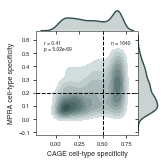

In [82]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_ts"])) & (~pd.isnull(all_activ["cage_ts"]))]
g = sns.jointplot(data=no_nan, x="cage_ts", y="mpra_ts", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategrey")
g.ax_joint.axhline(y=0.2, color="black", linewidth=1, linestyle="dashed")
g.ax_joint.axvline(x=0.5, color="black", linewidth=1, linestyle="dashed")
g.set_axis_labels("CAGE cell-type specificity", "MPRA cell-type specificity")
r, p = stats.spearmanr(no_nan["cage_ts"], no_nan["mpra_ts"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                    fontsize=5)
g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.5, .8), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("Fig_1D.pdf", bbox_inches="tight", dpi="figure")

In [83]:
def cage_v_mpra_ts(row):
    if row["cage_ts"] > 0.5 and row["mpra_ts"] > 0.2:
        return "ts in both"
    elif row["cage_ts"] > 0.5 and row["mpra_ts"] <= 0.2:
        return "ts in cage, not mpra"
    elif row["cage_ts"] <= 0.5 and row["mpra_ts"] > 0.2:
        return "ts in mpra, not cage"
    else:
        return "not ts in both"
    
no_nan["ts_status"] = no_nan.apply(cage_v_mpra_ts, axis=1)
no_nan.ts_status.value_counts()

not ts in both          692
ts in both              402
ts in mpra, not cage    310
ts in cage, not mpra    236
Name: ts_status, dtype: int64

In [84]:
tot = 692+402+310+236
upper_left = 310
upper_right = 402
lower_left = 692
lower_right = 236
print("upper left: %s" % (upper_left/tot))
print("upper right: %s" % (upper_right/tot))
print("lower left: %s" % (lower_left/tot))
print("lower right: %s" % (lower_right/tot))

upper left: 0.18902439024390244
upper right: 0.2451219512195122
lower left: 0.4219512195121951
lower right: 0.14390243902439023


In [85]:
(692+402)/(692+402+310+236)

0.6670731707317074

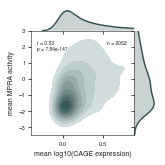

In [86]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_activ"])) & (~pd.isnull(all_activ["cage_activ"]))]
g = sns.jointplot(data=no_nan, x="cage_activ", y="mpra_activ", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, xlim=(-0.4, 0.9), ylim=(-3.5, 3), cmap=cmap, color="darkslategray")
g.set_axis_labels("mean log10(CAGE expression)", "mean MPRA activity")
r, p = stats.spearmanr(no_nan["cage_activ"], no_nan["mpra_activ"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.06, .75), xycoords=ax.transAxes, 
                    fontsize=5)
g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.48, .8), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("Fig_S5.pdf", bbox_inches="tight", dpi="figure")

## 8. compare MPRA and CAGE to RNA-seq

In [87]:
rna_seq_exp = rna_seq_exp[["gene_id", "HepG2", "HeLa-S3", "K562"]]
rna_seq_exp.columns = ["gene_id", "HepG2_rna_seq", "HeLa_rna_seq", "K562_rna_seq"]
rna_seq_exp["HepG2_rna_seq_log"] = np.log10(rna_seq_exp["HepG2_rna_seq"]+1)
rna_seq_exp["HeLa_rna_seq_log"] = np.log10(rna_seq_exp["HeLa_rna_seq"]+1)
rna_seq_exp["K562_rna_seq_log"] = np.log10(rna_seq_exp["K562_rna_seq"]+1)
all_activ_rna_seq = all_activ.merge(rna_seq_exp, on="gene_id")
all_activ_rna_seq["av_rna_seq"] = all_activ_rna_seq[["HepG2_rna_seq_log", "HeLa_rna_seq_log", "K562_rna_seq_log"]].mean(axis=1)
all_activ_rna_seq.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,cage_ts,mpra_activ,mpra_ts,HepG2_rna_seq,HeLa_rna_seq,K562_rna_seq,HepG2_rna_seq_log,HeLa_rna_seq_log,K562_rna_seq_log,av_rna_seq
1180,WILDTYPE__Lincrna.noflip.NA__chr8:100025222..1...,CCCTGCTAGTTAGGACAAAGCTCTAGGAGGTGTCTAAGGGGGTGGG...,WILDTYPE,div_lnc,1.690206,-0.514866,1.182881,not sig,sig active,sig active,...,0.161868,0.786074,0.078194,4.705392,3.279220,8.380103,0.756285,0.631365,0.972208,0.786619
707,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr5:585...,TGGGCGCTGGGCTTTTCTTTTTTTTTTTTTTTTTTTTTCCTTTCTC...,WILDTYPE,protein_coding,-1.223629,-1.629456,-2.082061,not sig,not sig,not sig,...,0.666667,-1.645048,0.313398,5.822239,73.744460,0.062919,0.833927,1.873579,0.026500,0.911335
376,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr17:5...,TCTAAAGACTGGGGCGGCCGTGAGGTCATCGGTGGTCGCCGGGAGC...,WILDTYPE,div_pc,-0.522064,-1.448104,-1.547708,not sig,sig active,sig active,...,0.386208,-1.172625,0.182598,12.919017,11.902714,7.969397,1.143609,1.110681,0.952763,1.069018
1352,WILDTYPE__mrna.noflip.NA__chr12:49412557..4941...,CGCCGGAAGGGTGGGTTCCTTGCCTTCCGCCCCAGTCTGGCGACTG...,WILDTYPE,protein_coding,3.300658,1.766717,3.199750,sig active,sig active,sig active,...,0.321447,2.755709,0.080518,19.944142,131.233689,74.650627,1.321063,2.121342,1.878813,1.773739
84,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,CCCAGGATTGACTGGCCCTTCCACCCAACCAGGGCGGTCTACACCC...,WILDTYPE,intergenic,2.663553,1.119288,2.379846,sig active,sig active,sig active,...,0.423166,2.054229,0.067425,0.252739,0.000000,0.070818,0.097861,0.000000,0.029716,0.042525


In [88]:
all_activ_rna_seq.PromType2.value_counts()

protein_coding    599
intergenic        425
div_lnc           353
div_pc            137
Name: PromType2, dtype: int64

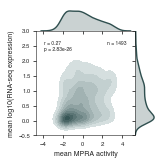

In [91]:
no_nan = all_activ_rna_seq[(~pd.isnull(all_activ_rna_seq["mpra_activ"])) & 
                           (~pd.isnull(all_activ_rna_seq["av_rna_seq"]))]
g = sns.jointplot(data=no_nan, x="mpra_activ", y="av_rna_seq", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategray", ylim=(-0.5, 3))
g.set_axis_labels("mean MPRA activity", "mean log10(RNA-seq expression)")
r, p = stats.spearmanr(no_nan["mpra_activ"], no_nan["av_rna_seq"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                    fontsize=5)

# add n-value
g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.475, .8), xycoords=ax.transAxes, 
                    fontsize=5)

plt.show()
g.savefig("Fig_S5_2.pdf", bbox_inches="tight", dpi="figure")

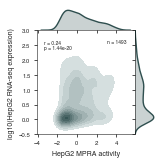

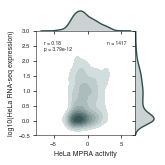

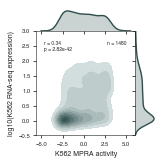

In [92]:
for cell in ["HepG2", "HeLa", "K562"]:
    mpra_col = cell
    seq_col = "%s_rna_seq_log" % cell
    
    no_nan = all_activ_rna_seq[(~pd.isnull(all_activ_rna_seq[mpra_col])) & (~pd.isnull(all_activ_rna_seq[seq_col]))]
    g = sns.jointplot(data=no_nan, x=mpra_col, y=seq_col, kind="kde", shade_lowest=False, size=2.3, space=0,
                      stat_func=None, cmap=cmap, color="darkslategray", ylim=(-0.5, 3))
    g.set_axis_labels("%s MPRA activity" % cell, "log10(%s RNA-seq expression)" % cell)
    r, p = stats.spearmanr(no_nan[mpra_col], no_nan[seq_col])
    g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                        fontsize=5)
    
    # add n-value
    g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.475, .8), xycoords=ax.transAxes, 
                        fontsize=5)
    
    plt.show()
    #g.savefig("%s_mpra_v_seq.pdf" % cell, bbox_inches="tight", dpi="figure")

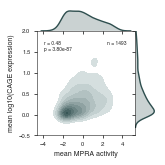

In [94]:
no_nan = all_activ_rna_seq[(~pd.isnull(all_activ_rna_seq["mpra_activ"])) & 
                           (~pd.isnull(all_activ_rna_seq["cage_activ"]))]
g = sns.jointplot(data=no_nan, x="mpra_activ", y="cage_activ", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategray", ylim=(-0.5, 2))
g.set_axis_labels("mean MPRA activity", "mean log10(CAGE expression)")
r, p = stats.spearmanr(no_nan["mpra_activ"], no_nan["cage_activ"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                    fontsize=5)

# add n-value
g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.475, .8), xycoords=ax.transAxes, 
                    fontsize=5)

plt.show()
g.savefig("Fig_S5_3.pdf", bbox_inches="tight", dpi="figure")

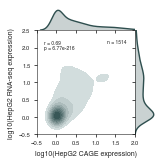

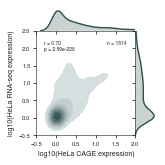

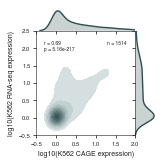

In [95]:
for cell in ["HepG2", "HeLa", "K562"]:
    cage_col = "%s_log_av" % cell
    seq_col = "%s_rna_seq_log" % cell
    
    no_nan = all_activ_rna_seq[(~pd.isnull(all_activ_rna_seq[cage_col])) & (~pd.isnull(all_activ_rna_seq[seq_col]))]
    g = sns.jointplot(data=no_nan, x=cage_col, y=seq_col, kind="kde", shade_lowest=False, size=2.3, space=0,
                      stat_func=None, cmap=cmap, color="darkslategray", ylim=(-0.5, 2.5), xlim=(-0.5, 2))
    g.set_axis_labels("log10(%s CAGE expression)" % cell, "log10(%s RNA-seq expression)" % cell)
    r, p = stats.spearmanr(no_nan[cage_col], no_nan[seq_col])
    g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                        fontsize=5)
    
    # add n-value
    g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.475, .8), xycoords=ax.transAxes, 
                        fontsize=5)
    
    plt.show()
    #g.savefig("%s_cage_v_seq.pdf" % cell, bbox_inches="tight", dpi="figure")

## 10. write final files

In [96]:
# write file with tissue-specificities for later use
final = all_activ[["unique_id", "PromType2", "cage_activ", "cage_ts", "mpra_activ", "mpra_ts"]]
final.to_csv("../../data/02__activs/POOL1__pMPRA1__CAGE_vs_MPRA_activs.txt", sep="\t", index=False)

In [97]:
# also write file with tss types
sel_map_expr.to_csv("../../misc/00__tss_properties/CAGE_expr_properties.txt", sep="\t", index=False)